In [1]:
# Initializing some things
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.marker'] = "o"
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.labelspacing'] = 0.0
cmap = mpl.cm.get_cmap(name='YlOrRd')
colors3 = [cmap(x) for x in [0.4, 0.6, 0.9]]

# Magnets: How do they work? Exploring the 2D Ising model
Magnetism on a microscopic level is caused by electrons in the atom "shells". The Ising model is a intuitive but powerful way of describing such a system. In this notebook, we'll first learn about the Ising model and try to get some intuition for it. To look into the physical consequences, we'll solve it numerically with my c++ solver magneto. Code for that program and this notebook is on [github.com/s9w/magneto](https://github.com/s9w/magneto). After the physics, we'll learn about the algorithms that are used to solve it and their differences and peculiarities [at the end of the article](#algorithms).

## Ising

Quantum Mechanics tells us that electrons have a property called spin which is in one of two states, usually called "up" and "down". In **Ising model**, that is represented by $\sigma=+1$ and $\sigma=-1$, with $\sigma$ just being the standard symbol for spin states. The spins are arranged in a two or three dimensional square lattice. We'll look at two dimensions here. Example for a small 4x4 system:

```
+1 +1 -1 +1
-1 -1 +1 +1
-1 +1 -1 -1
+1 -1 -1 +1
```

The behaviour of all physical systems boils down to minimizing the overall energy. So let's try to reason about the energy of such a system: Each electron spin produces either a positive or negative magnetic field. But it's also influenced by such fields, both external and those of the other spins. So there is an interaction between them. In good approximation, it's enough to only look at the interaction between next neighbor spins. So each spin only is affected by its four direct adjacent spins.

A positive field will push an electron spin towards a positive alignment and vice versa. So it's intuitive that without external fields and disturbances, a configuration where many spins are parallel (in the same state) is energetically beneficial. Put into an equation, the energy of the whole system (without an external magnetic field) is given by the Hamiltonian:

$$H = -J\sum_{\langle ij\rangle } \sigma_i \sigma_j$$

That way of writing a sum just means a summation over next neighbors for every single spin. We'll assume the coupling constant $J=1$ for the moment, more on that later.

Real systems consist of an astronomical number of spins, so a large lattice is crucial for good numerical results. To help cope with "finite size effects", periodic boundary conditions are used. So for a 2x2 grid with either all positive or all negative spins, the energy would be -8. Usually the energy is divided by the number of sites in the grid so that it's in a nice range between -2 and 0.

So we know what energy a specific configuration has. But a square grid with length $L$ has $L^2$ positions, which amounts to $2^{(L^2)}$ possible states. Even with conservative grid sizes that's a large number. Which of those configurations are actually physically realized and how often? More precise: What's their probability distribution? Statistical mechanics has the answer: The **Boltzmann distribution**

$$\exp\left(-\frac{H}{T}\right)$$

Normalized, it looks like this:

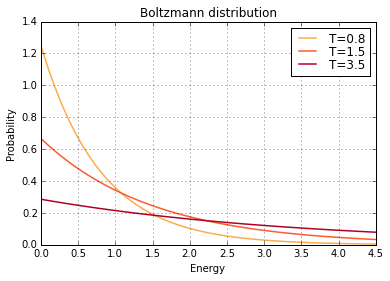

In [26]:
ax = plt.subplot(xlabel="Energy", ylabel="Probability", title="Boltzmann distribution")
E = np.linspace(0, 4.5, num=50)

for i, T in enumerate([0.8, 1.5, 3.5]):
    ax.plot(E, 1.0/T*np.exp(-E/T), "-", label="T={}".format(T), color=colors3[i])
ax.legend();

It depends on the system temperature $T$. As expected, configurations with the lowest total energy are always the most probable. But at high temperatures, the distribution becomes flatter and states with higher energies become more likely. Therefore we expect the average total energy to increase with temperature.

Physical interpretation: A higher temperature increases thermal energy and therefore thermal fluctuations. They compete with the magnetic interactions between the spins. While the magnetic forces will push the system towards parallel alignments (uniform state), thermal effects have a random nature. With high T, the thermal effects get stronger and eventually dominate over the spin interactions.

Now we got everything we need. To recap: Ising model says we can write such a system as grids with $\pm 1$; the Hamiltonian gives the relationship between a spin configuration and its energy; the Boltzmann distribution gives us a probability for each energy. So when we have algorithms to get system configurations that follow these rules, we can do physics. We'll do physics first, then look at the algorithms later.

To visualize how a typical system looks at different temperatures, we'll run a first simulation. The two spin states are represented with white and black. Note that all simulation inputs are included, but commented out because some of them run quite long. For documentation of the use of magneto itself, have a look at the [github repo](https://github.com/s9w/magneto).

In [27]:
# !magneto -N1=20000 -N2=0 -TMin=1.3 -TMax=3.3 -L=62 -TSteps=3 -states=states -alg1=metro

def draw_state(ax, grid, title):
    ax.grid(False)
    ax.imshow(grid, cmap=plt.cm.Greys, interpolation="none")
    ax.set_title(title)

def load_states(filename):
    with open(filename) as f:
        T = float(f.readline())
    grid = np.loadtxt(filename, delimiter=",", skiprows=1)
    return T, grid

def draw_states(filename_base, n=3):
    fig = plt.figure(figsize=(3*n, n))
    for i in range(n):
        T, grid = load_states(filename="{}{}.txt".format(filename_base, i))
        ax = fig.add_subplot(1, 3, i+1)
        draw_state(ax, grid, "T={:.2f}".format(T))
    fig.tight_layout()

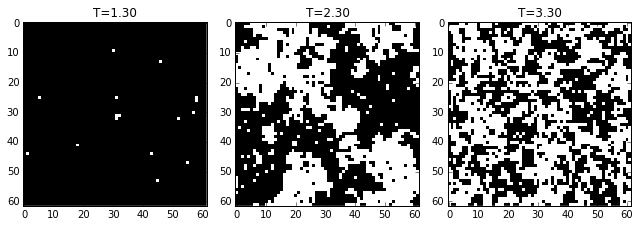

In [28]:
draw_states("states", 3)

As expected! At low temperatures, there is little thermal energy and the spin interactions dominate. This results in mostly uniform states. With rising temperatures, the thermal fluctuations become stronger and eventually turn the system into random noise.

## Energy, heat capacity and phase transitions
To get into physical details, we'll first look at the **energy**. It was defined with the Hamiltonian above. We expected it to increase with temperature.

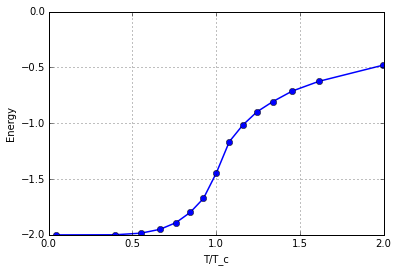

In [4]:
# !magneto -L=30 -TSteps=15 -en=energy -dist=normal
Tc = 2.0/np.log(1+np.sqrt(2))
ax = plt.subplot(111, xlabel="T/T_c", ylabel="Energy", ylim=(-2,0), xlim=(0,2))
T, E = np.loadtxt("energy.txt", delimiter=", ", unpack=True)
ax.plot(T/Tc, E);

As expected! Here, the temperature on the x-axis was divided by a special temperature $T_c$ called the **critical** or **Curie temperature**. That's because a lot of things happen with systems like this at that point.

To see that, we first have a look at the (specific) **heat capacity** $c_V$ of the system. It's a value that characterizes how much heat can be stored. Specifically: when you add an amount of heat $Q$ to a system and its temperature changes by $\Delta T$, the heat capacity is $\frac{Q}{\Delta T}$. Metal has a high heat capacity so it'll barely heat up if you add a certain amount of heat. But something like air will!

Statistical mechanics gives us two ways of calculating $c_V$. One is simply the temperature derivation of energy. The other is from its [variance](http://en.wikipedia.org/wiki/Variance). 

$$c_V = \frac{dE}{dT} = \frac{1}{T^2}(\langle E^2\rangle - \langle E\rangle^2)$$

Let's look at both:

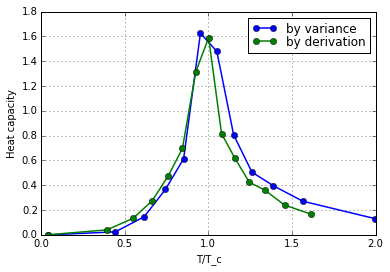

In [29]:
# !magneto -L=30 -TSteps=12 -cv=cv -dist=normal
ax = plt.subplot(xlabel="T/T_c", ylabel="Heat capacity")

# variance
T, cv = np.loadtxt("cv.txt", delimiter=", ", unpack=True)
ax.plot(T/Tc, cv, label="by variance")

# derivation
T, E = np.loadtxt("energy.txt", delimiter=", ", unpack=True)
ax.plot(T[:-1]/Tc, np.diff(E)/np.diff(T), label="by derivation")

ax.legend();

We see that both ways yield equal results up to a factor and numerics. The heat capacity has a peak right at $T_c$. The 2D Ising system has been solved analytically, so the value of $T_c$ is known exactly:

$$T_c=\frac{2}{\ln(1+\sqrt 2)}\approx 2.269$$

The peak looks sharp. In fact, the heat capacity diverges at $T_c$ if you would run the simulation on an infinitely large lattice etc!

## Magnetization, Susceptibility and Correlation
Now we look at the **magnetization** of the total system, which is just the sum over all spins. It's basically what is left after the internal spin interactions. A nonzero magnetization generates a magnetic field!

Systems with all negative or all positive spins result in the same energy. Usually the absolute value is used. It makes the plots prettier and the calculations easier. So the (absolute) magnetization is $\lvert m \rvert=\lvert \sum \sigma_i \rvert$.

If we recall how the systems looked, it's easy to predict that magnetization should be at its maximum for low temperatures as those caused uniform systems. The mostly equal spins add up to some value. At high temps there should be equal numbers of both spins, so we expect the magnetization to vanish. Let's have a look:

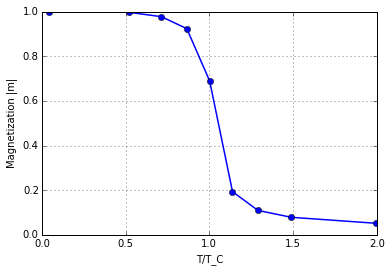

In [6]:
# !magneto -L=30 -TSteps=12 -N2=200 -mag=mag -dist=normal
ax = plt.subplot(xlabel="T/T_C", ylabel="Magnetization |m|", xlim=(0,2), ylim=(0,1))
T, m = np.loadtxt("mag.txt",  delimiter=", ", unpack=True)
ax.plot(T/Tc, m);

Bingo! And now it's easy to see why $T_c$ is so important. It's the temperature where the magnetization of the system becomes zero. More generally, the system undergoes a **phase transition**, which is an important concept in physics. Usually there are two types of phase transitions: "First order" ones, for example the boiling and evaporating of water. And "second order" or continuous transitions like this system, which is actually a model for the transition between the **ferromagnetic** and **paramagnetic** phase.

**Ferromagnetism** means that when an external magnetic field is applied, the electron spins lign up with it and cause themselves a big magnetization. This only works at temperatures below the critical point. We saw that at low temperatures, the spins are mostly uniform and that mostly positive or negative states are energetically identical and therefore equally probable. When even a small external field is applied, they'll easily align to it.

Above $T_c$, magnetization is heavily disturbed by thermal fluctuations. An external field can still "force" the spins to align, but this **paramagnetism** is typically much weaker than ferromagnetism. Common magnets you can buy are therefore all in the ferromagnetic phase. They would lose their strength above their Curie temperature, which is quite high for quantum reasons.

How strong a system reacts to an external field is quantified by the magnetic **susceptibility** $\chi$. There are several ways to calculate it. One is by variance of the magnetization:

$$\chi=\frac{1}{T}(\langle m^2\rangle - \langle m\rangle^2)$$

The other is to look at the **correlation** between two spins $\sigma_i$ and $\sigma_j$, measured by the **correlation function**:

$$G(i,j) = \langle\sigma_i \sigma_j\rangle - \langle\sigma_i\rangle \langle\sigma_j\rangle $$

We can rewrite that as $G(d)$ with the distance between spins $d=\lvert i-j\rvert$. It's intuitive that the correlation between spins decreases with distance. In fact it's proportional to an exponential function: $G(d)\sim \exp(-\frac d \xi)$. The parameter $\xi$ is called **correlation length** and summarizes the character of the correlation. It can be interpreted as average size of clusters or as typical range of spin fluctuations. Let's look at some correlation functions:

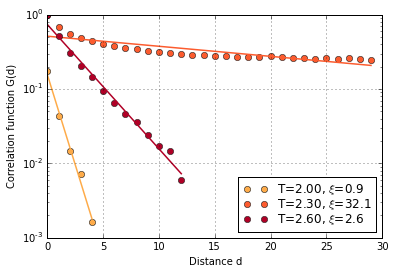

In [21]:
# !magneto -L=60 -TSteps=9 -TMin=2.0 -TMax=2.6 -N2=100 -N3=1000 -corr=chi_corrfun -alg1=metro -N1=5000

def corr_fun(x, corr_len, a):
    return np.exp(-x/corr_len)*a

def ln_corr_fun(x, corr_len, a):
    return -x/corr_len + np.log(a)

def lower_range(data, threshold):
    end_index = np.argmax(data<threshold)
    if end_index == 0:
        end_index = len(data)
    return data[:end_index]

ax = plt.subplot(xlabel="Distance d", ylabel="Correlation function G(d)")
data = np.loadtxt("chi_corrfun.txt",  delimiter=", ")

for i, T_index in enumerate([0,4,-1]):
    [T], corr_fun_data = np.split(data[T_index], [1])    
    corr_fun_data = lower_range(corr_fun_data, threshold = 0.001)
    
    distance = np.arange(corr_fun_data.size)
    corr_fun_data = np.log(corr_fun_data)
    [xi, a], _ = curve_fit(ln_corr_fun, distance, corr_fun_data)
    ax.semilogy(distance, np.exp(corr_fun_data), "o", color=colors3[i], label="T={:.2f}, $\\xi$={:.1f}".format(T, xi))
    ax.semilogy(distance, np.exp(ln_corr_fun(distance, xi, a)), "-", color=colors3[i])

plt.legend(loc="lower right");

The correlation vanishes in the distance - good! But at $T_c$ it does so infinitely slow, or: The correlation length $\xi$ is infinitely long. At least it would be if the lattice would be that big. In practice, $\xi$ is as big as the lattice itself! That means the spins correlate and interact with each other over the entire lattice!

To illustrate this, we'll look at the system at these exact temperatures and sizes again. With enough good will, the correlation length can be imagined as the average cluster size.

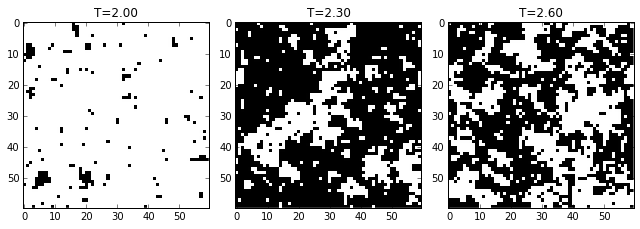

In [8]:
# !magneto -N1=10000 -N2=0 -TMin=2.0 -TMax=2.6 -L=60 -TSteps=3 -states=states_corr -alg1=metro
draw_states("states_corr", n=3)

Since $G$ was an exponential function which quickly went to 0, the fit isn't trivial. The small values are difficult to pin down precisely and were cut at a threshold. That's also the reason why it's next to impossible to calculate correlations at very high or low temperatures: The correlation is simply too small to reasonably do numerics with it.

Also at $T_c$ it can be seen that the finite size of the lattice becomes a problem since the first few values make the result much worse. They could be "discussed away", depending on mood and effort.

The connection beween correlation lenght and susceptibility is given by

$$\chi \sim \frac 1 T \xi$$

Before we look at that connection in more detail, let's calculate the susceptibility with the two discussed methods:

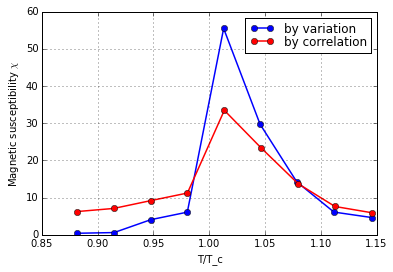

In [30]:
# !magneto -L=60 -TMin=2.0 -TMax=2.6 -TSteps=9 -N2=1000 -N3=500 -chi=chi -dist=normal -N1=1000

ax = plt.subplot(xlabel="T/T_c", ylabel="Magnetic susceptibility $\chi$")
T, chi = np.loadtxt("chi.txt",  delimiter=", ", unpack=True)
ax.plot(T/Tc, chi, label="by variation")

data = np.loadtxt("chi_corrfun.txt",  delimiter=", ")
T = data[:,0]
chi_corrfun = []
for i in range(9):
    _, corr_fun_data = np.split(data[i], [1])
    corr_fun_data = lower_range(corr_fun_data, threshold = 0.01)
    distance = np.arange(corr_fun_data.size)
    [xi, a], _ = curve_fit(ln_corr_fun, distance, corr_fun_data)
    chi_corrfun.append(xi/T[i])

ax.plot(np.asarray(T/Tc), np.asarray(chi_corrfun), "red", label="by correlation")
plt.legend();

The reason it's called susceptibility is also clear when you look at a third way of calculating it: It's the factor between an externally applied magnetic field, and the resulting field (magnetization) of the system. Or: It's a measure of how strong the system responds to external fields.

The susceptibility can be used to look at the **critical behaviour** with more detail. Not only does it diverge at $T_c$, but like many properties it follows a power law. If we define a "reduced temperature" $\tau=\frac{T-T_c}{T_c}$, then $\chi$ is on both sides of the divergence proportional to $\lvert\tau\rvert^{-\gamma}$. That $\gamma$ is called a **critical exponent**.

For our 2D ising case, the theoretical value is $\frac 7 8$. Let's try to calculate it with a fit. We'll do the same calculation, but closer "zoomed in" and with a longer calculation.

gamma: 1.58, deviation: -9.9%


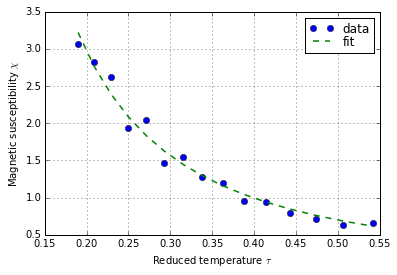

In [31]:
# magneto run takes about 30 secs
# !magneto -L=100 -TSteps=15 -N2=800 -N3=15 -chi=chi_exp -TMin=2.7 -TMax=3.5 -dist=normal
ax = plt.subplot(111, xlabel="Reduced temperature $\\tau$", ylabel="Magnetic susceptibility $\chi$")

# Fit
def chi_fit(tau, gamma, a):
    return a*np.power(tau,-gamma)
T, chi = np.loadtxt("chi_exp.txt", delimiter=", ", unpack=True)
tau = (T-Tc)/Tc
popt, pcov = curve_fit(chi_fit, tau, chi)

# Plot
ax.plot(tau, chi, "o", label="data")
ax.plot(tau, chi_fit(tau, *popt), "--", label="fit")
ax.legend(loc="upper right")

# Result
gamma = popt[0]; gamma0 = 1.75
print("gamma: {:.2f}, deviation: {:.1f}%".format(gamma, 100.0*(gamma-gamma0)/gamma0))

This is a difficult computation and it's fun to play around with the different algorithms, grid size, temperature ranges, N2, N3. This run took about 30 seconds on my machine and was within ±10%.

There are many other critical exponents and they can all be found like this. It's a very general principle that can be found not only in Ising models but many others.

## Finite size effects
So we have limited computer speed and therefore have to use a finite system size $L$. The effect of that is that the calculated values of $T_c$ drift away from the theoretical value for grids with smaller size. That drift can be used to extrapolate the ideal value for $L\to\infty$.

To do so, we use a trick: The critical temperature is plotted against the inverse grid size. The intersection of the fit with the $\frac 1 L =0$ (that means "$L=\infty$") line yields a much better value of $T_C$ than any of the direct computations.

We do that for some system sizes. There are different ways to get $T_c$ out of those plots. One way would be to take the peak position. But the data is often noisy, so a fit often is better. The correct function to fit would be $\lvert\tau\rvert^{-\gamma}$, but I found it very hard to make it converge. Instead we use a normal function. Example for one grid size:

In [11]:
# !magneto -L=8  -TSteps=9 -TMin=2.0 -TMax=3.5 -N2=1000 -N3=1000 -chi=chi_finite_8 -N1=2000
# !magneto -L=10  -TSteps=12 -TMin=2.2 -TMax=2.8 -N2=1000 -N3=500 -chi=chi_finite_10 -N1=2000
# !magneto -L=12  -TSteps=15 -TMin=2.0 -TMax=3.5 -N2=1000 -N3=50 -chi=chi_finite_12
# !magneto -L=16  -TSteps=15 -TMin=2.0 -TMax=3.5 -N2=1000 -N3=50 -chi=chi_finite_16
# !magneto -L=32  -TSteps=15 -TMin=1.8 -TMax=3.0 -N2=1000 -N3=50 -chi=chi_finite_32

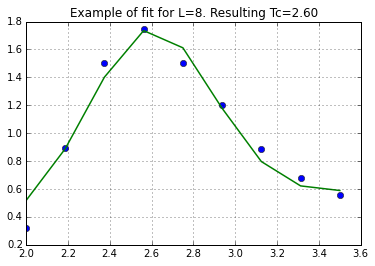

In [12]:
from scipy.stats import norm

def chi_fun(x, x0, sigma, a, b):
    return norm.pdf(x, x0, sigma)*b + x*a

L = 8
T, cv = np.loadtxt("chi_finite_{}.txt".format(L),  delimiter=", ", unpack=True)
popt, _ = curve_fit(chi_fun, T, cv, p0=[ 2.45, 0.1,  0.8,  0.6])
plt.title("Example of fit for L={}. Resulting Tc={:.2f}".format(L, popt[0]))
plt.plot(T, cv, "o")
plt.plot(T, chi_fun(T, *popt), "-");

And for all of them, with the fit:

Calculated Tc: 2.287, deviation: 0.78%


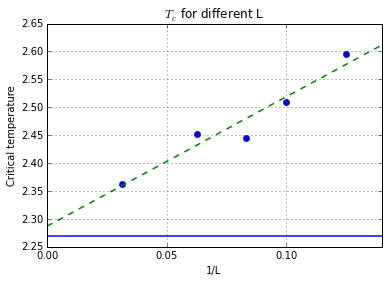

In [13]:
# Plot critical temps vs inverse grid sizes
grid_sizes = np.array([8,10,12,16,32])
L_inv = 1.0/grid_sizes

T_critical_array = []
for L in grid_sizes:
    T, cv = np.loadtxt("chi_finite_{}.txt".format(L),  delimiter=", ", unpack=True)
    popt, _ = curve_fit(chi_fun, T, cv, p0=[ 2.45, 0.1,  0.8,  0.6])
    Tc0 = popt[0]
    T_critical_array.append(Tc0)

ax = plt.subplot(xlabel="1/L", ylabel="Critical temperature", title="$T_c$ for different L")
ax.plot(L_inv, T_critical_array, "o")
ax.set_xticks(np.arange(0, 0.16, 0.05))

# Fit with a linear function
def T_fit(x,a,b):
    return a+b*x
popt, pcov = curve_fit(T_fit, L_inv, T_critical_array)
x = np.linspace(0, 0.14)
ax.plot(x, T_fit(x, *popt), "--")

# Result
gamma = popt[0]; gamma0 = 1.75
T_c_fit = T_fit(0, *popt)
print("Calculated Tc: {:.3f}, deviation: {:.2f}%".format(T_c_fit, 100.0*(T_c_fit-Tc)/Tc))
ax.axhline(y=Tc, marker="");

This fit was within 1% of the theoretical value!

## Algorithms
We've seen at the beginning that for a lattice length of $L$ there are $2^{L\cdot L}$ possible configurations. Now one could generate all of them and weigh them with the Boltzmann factor $e^{-H/T}$. A much better approach is to generate the system configurations in a way so that they come out Boltzmann distributed.

The most popular way to do this is the Metropolis algorithm. It's based on markov chains and uses an equilibrium condition called [detailed balance](http://en.wikipedia.org/wiki/Detailed_balance#Reversible_Markov_chains) to prove a simple assumption: If the system is in a state with energy $E_0$ and we flip the value of a single spin so that the system has now $E_1$, the probability to accept that change should be:

$$p=\min\left(1, \exp\left(-\frac{\Delta E}{T}\right)\right) \quad \text{ with } \Delta E=E_1-E_0$$

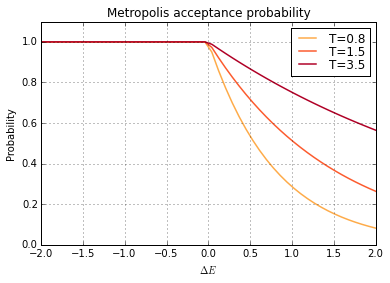

In [14]:
ax = plt.subplot(xlabel="$\Delta E$", ylabel="Probability", ylim=(0,1.1), title="Metropolis acceptance probability")
dE = np.linspace(-2, 2)

for i, T in enumerate([0.8, 1.5, 3.5]):
    ax.plot(dE, np.minimum(1, np.exp(-dE/T)), "-", label="T={}".format(T), color=colors3[i])
ax.legend();

That's quite simple and elegant! But Metropolis suffers from an effect called **critical slowing down**. That means it becomes increasingly ineffective near the critical temperature. To understand, recall that the system has large clusters of parallel spins there. Those clusters are energetically optimal. And because of their size, a single spin flip like in Metropolis isn't doing much.

As demonstration, we'll use a disk as an ideal cluster. We generate and save it with NumPy, then use it in magneto as starting configuration. The result is an animation of the first 100 metropolis sweeps on such a system.

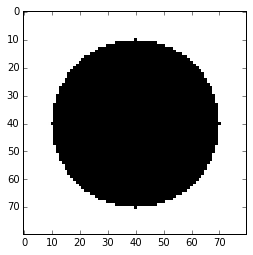

In [15]:
L=80; a=L//2; r=30
y,x = np.ogrid[-a:L-a, -a:L-a]
mask = x*x + y*y <= r*r
array = np.zeros((L,L), dtype=int)
array[mask] = 1

plt.grid(False)
plt.imshow(array, cmap=plt.cm.Greys, interpolation="none")
np.savetxt("circle.txt", array, fmt='%1u', delimiter=",")

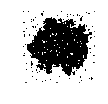

In [16]:
# !magneto -N1=0 -N3=1 -N2=100 -TMin=2.0 -L=80 -TSteps=1 -states=slowdown_metro -alg1=metro -initial=circle.txt -record=main
def writeIsingMovie(file_in, file_out):
    fig = plt.figure(figsize=(1,1))
    data = np.loadtxt(file_in,  delimiter=",", skiprows=1)
    L = data.shape[1]
    grids = np.split(data, data.shape[0]/L)
    images = []
    for grid in grids:
        images.append([plt.imshow(grid, cmap=plt.cm.Greys, interpolation ="none")])
        plt.axis('off')
        plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
    ani = animation.ArtistAnimation(fig, images, blit=True)
    ani.save(file_out, dpi=L*2, fps=25, extra_args=['-vcodec', 'libvpx', "-quality", "best", "-b:v", "350k"])

writeIsingMovie("slowdown_metro0.txt", "slowdown.webm")

In [17]:
%%html
<video controls loop autoplay>
  <source src="slowdown.webm">
</video>

Even after 100 sweeps the cluster still isn't completely gone!

There is another class of algorithms called **cluster algorithms**, especially **Swendsen-Wang**. It works by starting a BFS (Breadth-first search) at every grid point to cover the entire grid. But the cluster can only contain same spins and is limited by a probability similar to Metropolis. Cluster algorithms don't suffer from critical slowing down. For demonstration, let's look at the same disk configuration again and only look at the first three Swendsen-Wang steps.

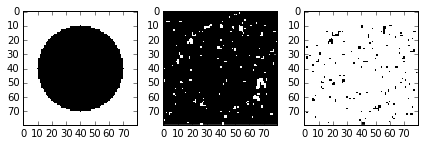

In [18]:
# !magneto -N1=0 -N3=1 -N2=5 -TMin=2.3 -L=80 -TSteps=1 -states=slowdown_sw -initial=circle.txt -record=main -alg2=sw
fig = plt.figure(figsize=(6,2))
data = np.loadtxt("slowdown_sw0.txt", delimiter=",", skiprows=1)
L = data.shape[1]
grids = np.split(data, data.shape[0]/L)
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.grid(False)
    ax.imshow(grids[i], cmap=plt.cm.Greys, interpolation="none")
fig.tight_layout()

It's gone almost instantly.

## Peak positions
Something to keep in mind is that $T_c$ itself is much more "off" with Swendsen-Wang. It'll still converge to the correct value for big L, but much slower so than Metropolis. Let's look at susceptibility just because it has such a nice peak.

In [19]:
# Metropolis
# !magneto -L=8  -TMin=1.9 -TMax=3.9 -TSteps=18 -N2=6000  -chi=chi_m8  -alg2=metro -N3=10
# !magneto -L=16 -TMin=1.9 -TMax=3.9 -TSteps=15 -N2=4000  -chi=chi_m16 -alg2=metro -N3=10
# !magneto -L=32 -TMin=1.9 -TMax=3.9 -TSteps=18 -N2=2000  -chi=chi_m32 -alg2=metro -N3=5

# Swendsen-Wang
# !magneto -L=16 -TMin=1.9 -TMax=3.9 -TSteps=9  -N2=5000 -chi=chi_sw16 -alg2=sw -N3=15
# !magneto -L=32 -TMin=1.9 -TMax=3.9 -TSteps=9  -N2=1000 -chi=chi_sw32 -alg2=sw -N3=10
# !magneto -L=50 -TMin=1.9 -TMax=3.9 -TSteps=12 -N2=1000 -chi=chi_sw50 -alg2=sw -N3=5

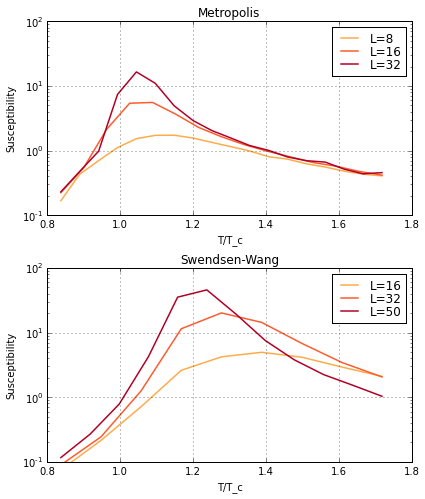

In [20]:
fig = plt.figure(figsize=(6,7))
L1 = [8,16,32]
Tc1 = []

ax = fig.add_subplot(211, xlabel="T/T_c", ylabel="Susceptibility", xlim=(0.8,1.8), title="Metropolis")
for i,L in enumerate(L1):
    T, cv = np.loadtxt("chi_m{}.txt".format(L), delimiter=", ", unpack=True)
    ax.plot(T/Tc, cv, marker="", label="L={}".format(L), color=colors3[i])
    Tc1.append( T[np.argmax(cv)] )
ax.set_yscale('log')
ax.set_ylim(0.1,100)
ax.legend(loc="upper right")

L2 = [16,32,50]
Tc2 = []
ax = fig.add_subplot(212, xlabel="T/T_c", ylabel="Susceptibility", xlim=(0.8,1.8), title="Swendsen-Wang")
for i,L in enumerate(L2):
    T, cv = np.loadtxt("chi_sw{}.txt".format(L), delimiter=", ", unpack=True)
    ax.plot(T/Tc, cv, marker="", label="L={}".format(L), color=colors3[i])
    Tc2.append( T[np.argmax(cv)] )
ax.set_yscale('log')
ax.set_ylim(0.1,100)
ax.legend(loc="upper right");
fig.tight_layout()

It can be seen that for both algorithms the peak height increases and the position converges towards the ideal for bigger systems. But the SW peak positions are much further away from the ideal. The correct critical temperature can still be measured with the finite size extrapolation (see above).